# Future Stock Prediction

In [1]:
import pandas as pd
from pandas.plotting import lag_plot

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error

import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape


from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

Things to do on Monday:

1. Finish off doing the price prediction using PROPHET
2. Stock prediction using GRU/LSTM
3. Figure out a way to turn these predictions into a strategy 

So the aim of this notebook will be to train ARIMA, PROPHET and LSTM/GRU models to predict future stock prices. In this notebook we will use Apple historical data. 

https://neptune.ai/blog/arima-vs-prophet-vs-lstm

In [2]:
stock = pd.read_csv('AAPL_FULL_2012_2022.csv', index_col  ='Date') # We need to do something with the index
print(len(stock))
def get_train_test_split(df):
    return df.iloc[:2000], df.iloc[2000:]

2517


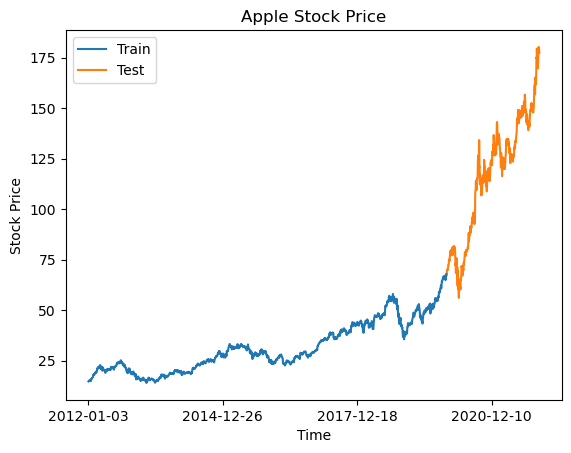

In [16]:
train, test = get_train_test_split(stock)
plt.plot(train.index, train['AAPL_Close'], label = 'Train')
plt.plot(test.index, test['AAPL_Close'], label = 'Test')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Apple Stock Price')
plt.xticks(np.arange(0, 2517, 750).tolist(), stock.index[0:2517:750].tolist())
plt.legend()
           
plt.show()

In order to create better predictions, we will feature engineer some lagging indicies based on information other than the close price:

- High, mean and std
- Low, mean and std
- Volume, mean and std

And we will do this for a variety of different lagging periods from 3 days to 30. 

In [4]:
def get_lagged_data(df, feature, window):
    return df[feature].rolling(window = window, min_periods = 0)

def get_lagged_mean(df, feature, window):
    lagged_data = get_lagged_data(df, feature, window)
    return lagged_data.mean().shift(1).reset_index()#.astype(np.float32)

def get_lagged_std(df, feature, window):
    lagged_data = get_lagged_data(df, feature, window)
    return lagged_data.std().shift(1).reset_index()#.astype(np.float32)

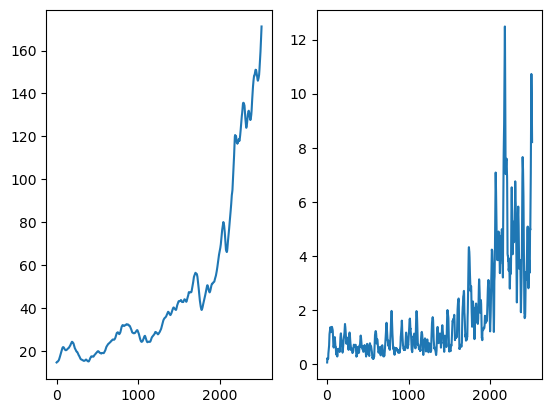

In [5]:
fig, axs = plt.subplots(ncols = 2)
axs[0].plot(get_lagged_mean(stock, 'AAPL_High', 30)['AAPL_High'])
axs[1].plot(get_lagged_std(stock, 'AAPL_High', 30)['AAPL_High'])
plt.show()


In [6]:
stock.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433824,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500644,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771556,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400


In [7]:
def get_lag_features(df):
    lag = [3, 7, 30]
    new = df.copy()
    for feature in df.columns:
        for l in lag:
            
            new[feature + f"_mean_lag{l}"] = get_lagged_mean(df, feature, l)[feature].to_list()
            new[feature + f"_std_lag{l}"] = get_lagged_std(df, feature, l)[feature].to_list()
    return new


stock_with_lagged_features = get_lag_features(stock)

In [8]:
stock_with_lagged_features.head(10)

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_Open_mean_lag3,AAPL_Open_std_lag3,AAPL_Open_mean_lag7,AAPL_Open_std_lag7,...,AAPL_Adj Close_mean_lag7,AAPL_Adj Close_std_lag7,AAPL_Adj Close_mean_lag30,AAPL_Adj Close_std_lag30,AAPL_Volume_mean_lag3,AAPL_Volume_std_lag3,AAPL_Volume_mean_lag7,AAPL_Volume_std_lag7,AAPL_Volume_mean_lag30,AAPL_Volume_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433824,302220800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500644,260022000,14.621429,NaN,14.621429,NaN,...,12.433824,NaN,12.433824,NaN,3.022208e+08,NaN,3.022208e+08,NaN,3.022208e+08,NaN
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600,14.632143,0.015151,14.632143,0.015151,...,12.467234,0.047249,12.467234,0.047249,2.811214e+08,2.983906e+07,2.811214e+08,2.983906e+07,2.811214e+08,2.983906e+07
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771556,318292800,14.694643,0.108782,14.694643,0.108782,...,12.524631,0.104879,12.524631,0.104879,2.778375e+08,2.185263e+07,2.778375e+08,2.185263e+07,2.778375e+08,2.185263e+07
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400,14.818095,0.174470,14.768929,0.173097,...,12.586362,0.150253,12.586362,0.150253,2.831948e+08,3.091164e+07,2.879513e+08,2.697252e+07,2.879513e+08,2.697252e+07
2012-01-10,15.211071,15.214286,15.053571,15.115714,12.796954,258196400,15.002619,0.188627,14.854429,0.242947,...,12.619350,0.149576,12.619350,0.149576,3.278623e+08,6.193437e+07,3.091659e+08,5.287663e+07,3.091659e+08,5.287663e+07
2012-01-11,15.095714,15.101786,14.975357,15.091071,12.776092,215084800,15.133095,0.122596,14.913869,0.261567,...,12.648951,0.152169,12.648951,0.152169,3.235045e+08,6.806382e+07,3.006710e+08,5.166945e+07,3.006710e+08,5.166945e+07
2012-01-12,15.081429,15.103571,14.955357,15.049643,12.741017,212587200,15.167738,0.062803,14.939847,0.248472,...,12.667114,0.146988,12.667114,0.146988,2.891019e+08,9.338740e+07,2.884444e+08,5.719445e+07,2.884444e+08,5.719445e+07
2012-01-13,14.989286,15.016071,14.952143,14.993214,12.693246,226021600,15.129404,0.071085,15.005561,0.207709,...,12.710998,0.105822,12.676352,0.138570,2.286228e+08,2.564192e+07,2.756396e+08,6.330352e+07,2.789622e+08,5.935638e+07


## ARIMA

In [9]:
train_data, test_data = get_train_test_split(stock)
y_train, y_test = train_data['AAPL_Close'].values, test_data['AAPL_Close'].values
print(len(y_train), len(y_test))

2000 517


### Pre Modelling Analysis

#### Autoregressive assumpition

Before we train out models, we must testing if it satisfies the assumpitions of ARIMA. In particular if we look at the lag plots, straight lines would suggest that autoregressive models will work well.

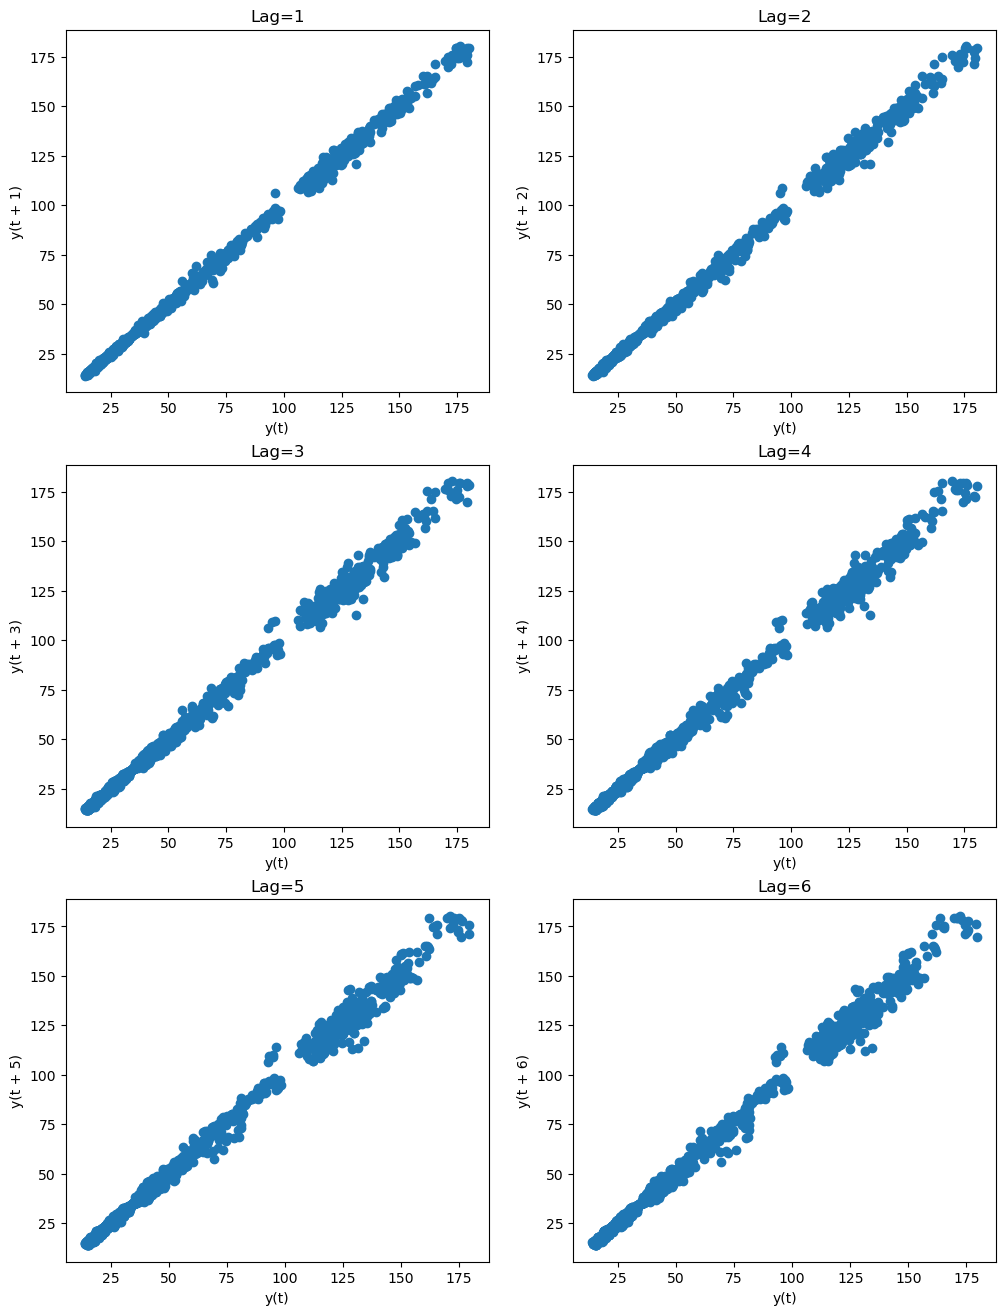

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(stock['AAPL_Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

These plots suggest that an autoregressive model will work well. Therefore when fitting we will let `auto_arima` to select a lag term. 

#### Estimating the Difference Term

We also need to estimate the number of times we must difference the series in order to ensure stationarity. 

In [11]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


i.e. we using two test (Augmented Dickie-Fuller) and Kwiatkowski-Phillips-Schmidt-Shin we observed that a first order differencing will be enough to ensure stationarity

### Further Parameter Selection

In [12]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3142.246, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3143.203, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3145.024, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3145.001, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3146.222, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3142.260, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3141.660, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3146.610, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3140.132, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3141.104, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3142.467, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3143.632, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 3.963 seconds


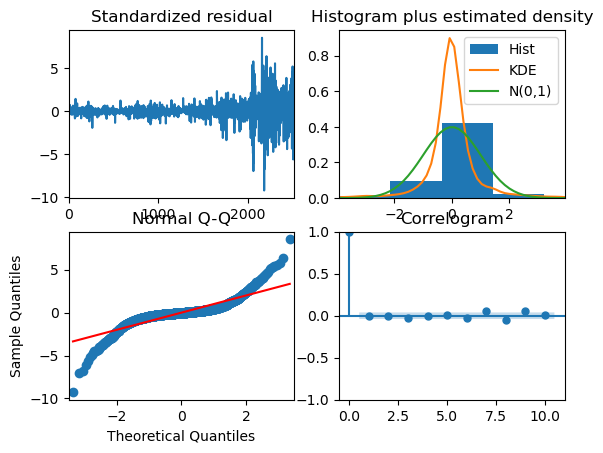

In [17]:
auto.plot_diagnostics();

So our best fit model takes:

- 2 autoregressive terms
- 1 differencing term

From plots we see that:

1. Standardised residuals are oscillated withing a few standard deviations as expected.
2. From the histogram, again the residuals look good
3. The QQ plot shows that the two distributions are similar in the middle, however the sampled DF has lighter tails (as it curves down on the left and up on the right)
4. Correlogram, we see that there is no trend in the autocorrelation

Basically this all looks good. Now lets plot the prediction

### Predictions

When predicting the value at t+1, we will update the model based on the  information that we have at time t. This will closer model the scenario of our model. 

In [14]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 5.755460158142547
SMAPE: 1.6030764528579717


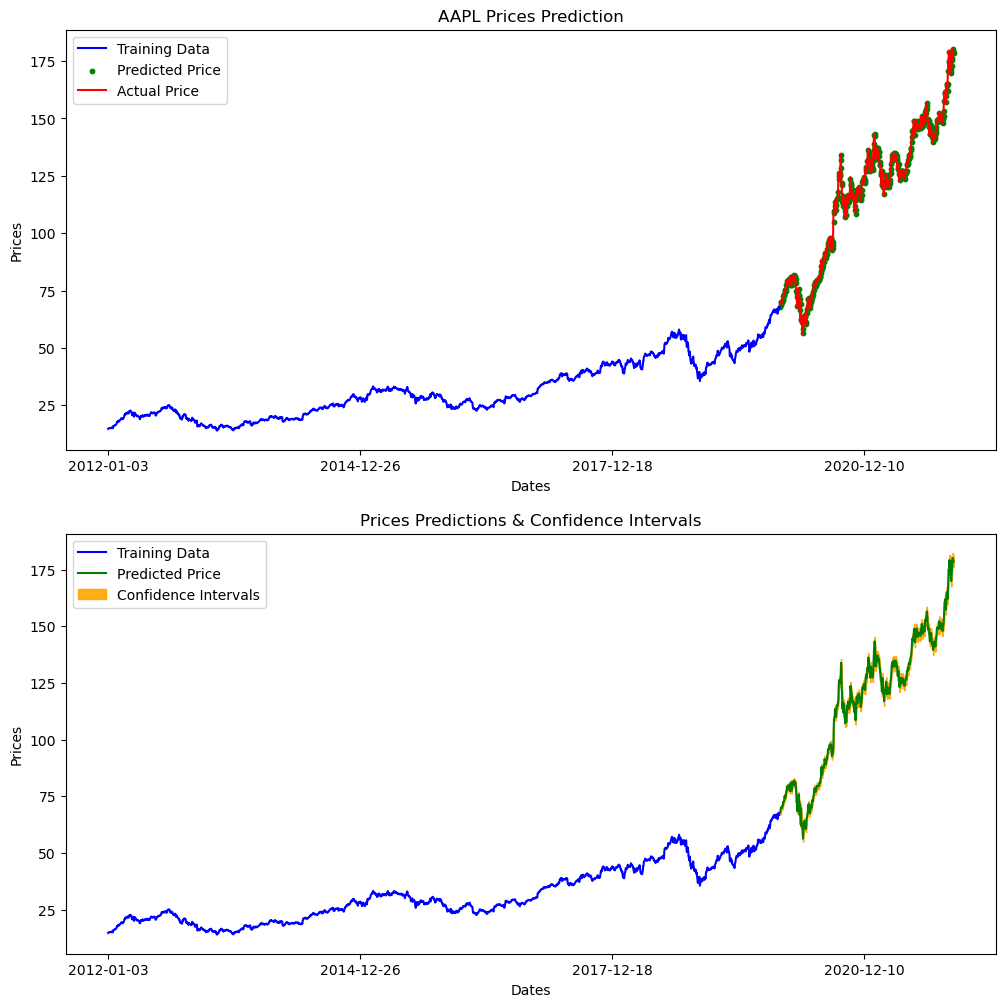

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[0].scatter(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price', s = 10)

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('AAPL Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].set_xticks(np.arange(0, 2517, 750).tolist(), stock.index[0:2517:750].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].set_xticks(np.arange(0, 2517, 750).tolist(), stock.index[0:2517:750].tolist())
axes[1].legend()
plt.show()

Okay, so I think this model is doing a very good job at predicting the price at the end of the following day. I think we could definitely turn this into a useful strategy. 

## Prophet

Now lets use the prohet model to model the evolution of stocks. First we will take our data and get it in the right form (Prophet expects the target to be labelled 'y' and the date to be lablled 'ds')

In [18]:
stock_prophet = pd.DataFrame({'y' : stock['AAPL_Close'].values, 'ds' : stock.index})
stock_prophet.head()

,y,ds
0,14.686786,2012-01-03
1,14.765714,2012-01-04
2,14.929643,2012-01-05
3,15.085714,2012-01-06
4,15.061786,2012-01-09


In [19]:
train_data_p, test_data_p = get_train_test_split(stock_prophet)

In [34]:
p_model = Prophet(daily_seasonality=False)
p_model.fit(train_data_p);

18:57:41 - cmdstanpy - INFO - Chain [1] start processing
18:57:41 - cmdstanpy - INFO - Chain [1] done processing


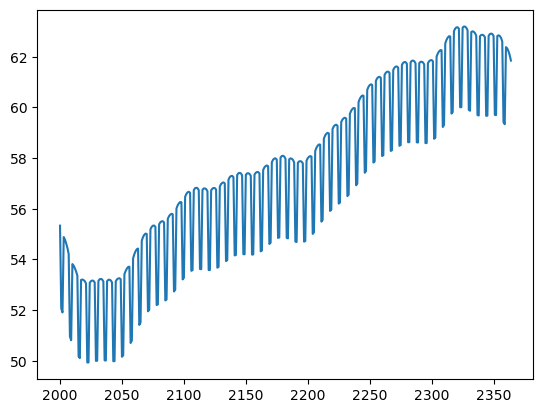

In [35]:

future = p_model.make_future_dataframe(periods=365)
p_forcast = p_model.predict(future)
p_forcast.head()

plt.plot(p_forcast.index[2000:], p_forcast['yhat'][2000:])
#plt.plot(train_data_p.index, train_data_p['y'])